### Outline

#### *Initialization and Data Loading:*

- Initialize a Spark session.
- Load data from HDFS using PySpark.

#### *Exploratory Data Analysis (EDA):*

- Check the schema of the DataFrame.
- Display the first few rows of the DataFrame.
- Perform basic EDA, including checking the number of rows, columns, and summary statistics.
- Handle null values by dropping rows with null values.

#### *Data Cleaning:*

- Perform additional data cleaning steps, including dropping rows with 'undefined' sentiment.
- Check and display null values again after cleaning.

#### *Data Exploration:*

- Explore the distribution of tweets among different companies.
- Visualize the count and percentage of company tweets.

#### *Sentiment Distribution:*

- Analyze and visualize the distribution of sentiment categories.
- Explore sentiment distribution across different companies.

#### *Text Analysis and Feature Engineering:*

- Convert the 'polarity' column to float and define a UDF for sentiment conversion.
- Apply the sentiment UDF to create a new 'sentiment' column.
- Explore and visualize text-related features such as character and token length distributions.

#### *Text Cleaning and Feature Engineering:*

- Use the neattext library for text cleaning.
- Tokenize, remove stop words, and apply TF-IDF to the text.

#### *Classification Models:*

- Train and evaluate Random Forest, Decision Tree, and Logistic Regression classifiers.
- Evaluate models based on accuracy, precision, recall, and F1-score.

#### *Sentiment Analysis Using Vader Lexicon:*

- Utilize the VADER and TextBlob SentimentIntensityAnalyzer for sentiment analysis.
- Define UDFs for sentiment score and category conversion.
- Apply sentiment analysis to the cleaned text.
- Visualize the distribution of sentiments using VADER VADER and TextBlob.

#### *Location-Based Analysis:*

- Analyze the count of unique location names.
- Group data by 'location', 'group_name', and 'SentimentCategory'.
- Pivot the table for better visualization of sentiment distribution across locations.


In [ ]:
pip install hdfs

In [ ]:
pip install pyspark

### *Initialization of Spark Session and Data Loading:*

In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("BigTechSentimentAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 12:54:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# HDFS path to your file
hdfs_path = 'hdfs://localhost:9000/user/saikumargandham/combined_bigtech.csv'

# Read the file into a PySpark DataFrame
df_spark = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
df_spark.printSchema()

# Display the first few rows of the DataFrame
df_spark.show()


root
 |-- created_at: timestamp (nullable = true)
 |-- file_name: string (nullable = true)
 |-- followers: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- group_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- screenname: string (nullable = true)
 |-- search_query: string (nullable = true)
 |-- text: string (nullable = true)
 |-- twitter_id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- partition_0: string (nullable = true)
 |-- partition_1: string (nullable = true)

+-------------------+---------+---------+-------+----------+--------------+-------------+--------------+------------+--------------------+--------------------+--------------------+--------+-----------+-----------+
|         created_at|file_name|followers|friends|group_name|      location|retweet_count|    screenname|search_query|                text|          twitter

### *EDA*

In [3]:
# Perform basic EDA
df_spark.printSchema()
print("Number of rows:", df_spark.count())
print("Number of columns:", len(df_spark.columns))

root
 |-- created_at: timestamp (nullable = true)
 |-- file_name: string (nullable = true)
 |-- followers: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- group_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- screenname: string (nullable = true)
 |-- search_query: string (nullable = true)
 |-- text: string (nullable = true)
 |-- twitter_id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- partition_0: string (nullable = true)
 |-- partition_1: string (nullable = true)

Number of rows: 1133004
Number of columns: 15


In [4]:
# Display summary statistics
df_spark.describe().show()

23/12/12 12:55:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+------------------+------------------+----------+-----------------+------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|file_name|         followers|           friends|group_name|         location|     retweet_count|          screenname|search_query|                text|          twitter_id|            username|            polarity|         partition_0|         partition_1|
+-------+---------+------------------+------------------+----------+-----------------+------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|  1133004|           1133004|           1133004|   1133004|           810400|           1133004|             1133004|     1133004|             1133002|             1132994|             1132964|

In [5]:
from pyspark.sql.functions import col, sum

# Check null values in each column
null_counts = df_spark.agg(*[sum(col(c).isNull().cast("int")).alias(c + '_null_count') for c in df_spark.columns])

# Display the null counts
null_counts.show()


+---------------------+--------------------+--------------------+------------------+---------------------+-------------------+------------------------+---------------------+-----------------------+---------------+---------------------+-------------------+-------------------+----------------------+----------------------+
|created_at_null_count|file_name_null_count|followers_null_count|friends_null_count|group_name_null_count|location_null_count|retweet_count_null_count|screenname_null_count|search_query_null_count|text_null_count|twitter_id_null_count|username_null_count|polarity_null_count|partition_0_null_count|partition_1_null_count|
+---------------------+--------------------+--------------------+------------------+---------------------+-------------------+------------------------+---------------------+-----------------------+---------------+---------------------+-------------------+-------------------+----------------------+----------------------+
|                    0|           

In [6]:
# Drop rows with any null values
df_spark= df_spark.na.drop()

# Show the cleaned DataFrame
df_spark.show()

+-------------------+---------+---------+-------+----------+--------------------+-------------+-------------+------------+--------------------+--------------------+--------------------+--------+-----------+-----------+
|         created_at|file_name|followers|friends|group_name|            location|retweet_count|   screenname|search_query|                text|          twitter_id|            username|polarity|partition_0|partition_1|
+-------------------+---------+---------+-------+----------+--------------------+-------------+-------------+------------+--------------------+--------------------+--------------------+--------+-----------+-----------+
|2020-07-12 09:24:26|      AMD|       25|    114|       AMD|      United Kingdom|          0.0|moffphcgaming|        #AMD|Been on holiday s...|1.282244417466884...|  🕹MoffPHC Gaming🕹| -0.3102| Technology|        AMD|
|2020-07-12 09:09:36|      AMD|      159|   1144|       AMD|        digitalverse|          4.0|   ironparr0t|        #AMD|RT @

In [7]:
# Check null values in each column and get the count
null_counts = df_spark.agg(*[sum(col(c).isNull().cast("int")).alias(c + '_null_count') for c in df_spark.columns])

# Display the null counts
null_counts.show()

+---------------------+--------------------+--------------------+------------------+---------------------+-------------------+------------------------+---------------------+-----------------------+---------------+---------------------+-------------------+-------------------+----------------------+----------------------+
|created_at_null_count|file_name_null_count|followers_null_count|friends_null_count|group_name_null_count|location_null_count|retweet_count_null_count|screenname_null_count|search_query_null_count|text_null_count|twitter_id_null_count|username_null_count|polarity_null_count|partition_0_null_count|partition_1_null_count|
+---------------------+--------------------+--------------------+------------------+---------------------+-------------------+------------------------+---------------------+-----------------------+---------------+---------------------+-------------------+-------------------+----------------------+----------------------+
|                    0|           

In [8]:
# Assuming df_spark is your DataFrame
column_data_types = df_spark.dtypes

# Display the data types of each column
for col_name, col_type in column_data_types:
    print(f"Column: {col_name}, Data Type: {col_type}")


Column: created_at, Data Type: timestamp
Column: file_name, Data Type: string
Column: followers, Data Type: int
Column: friends, Data Type: int
Column: group_name, Data Type: string
Column: location, Data Type: string
Column: retweet_count, Data Type: string
Column: screenname, Data Type: string
Column: search_query, Data Type: string
Column: text, Data Type: string
Column: twitter_id, Data Type: string
Column: username, Data Type: string
Column: polarity, Data Type: string
Column: partition_0, Data Type: string
Column: partition_1, Data Type: string


In [10]:
from pyspark.sql.functions import col

def basic_eda(df_spark, row_limit=5, list_elements_limit=10):
    # Rows and columns
    print('Info : There are {} columns in the dataset'.format(len(df_spark.columns)))
    print('Info : There are {} rows in the dataset'.format(df_spark.count()))

    print("==================================================")

    # Data types
    print("\nData type information of different columns")
    dtypes_df_spark = df_spark.dtypes
    cat_cols = [col_name for col_name, col_type in dtypes_df_spark if col_type == 'string']
    num_cols = [col_name for col_name, col_type in dtypes_df_spark  if col_type != 'string']
    
    print('Info : There are {} categorical columns'.format(len(cat_cols)))
    print('Info : There are {} numerical columns'.format(len(num_cols)))

    if list_elements_limit >= len(cat_cols):
        print("Categorical columns : ", cat_cols)
    else:
        print("Categorical columns : ", cat_cols[:list_elements_limit])

    if list_elements_limit >= len(num_cols):
        print("Numerical columns : ", num_cols)
    else:
        print("Numerical columns : ", num_cols[:list_elements_limit])

    # Display data types
    for col_name, col_type in dtypes_df_spark :
        print("{}: {}".format(col_name, col_type))

    print("==================================================")
    print("\nDescription of numerical variables")

    # Describing numerical columns
    df_spark .select(num_cols).describe().show(row_limit)

    print("==================================================")
    print("\nDescription of categorical variables")

    # Describing categorical columns
    df_spark.select(cat_cols).describe().show(row_limit)

    return

In [11]:
basic_eda(df_spark)

Info : There are 15 columns in the dataset


Info : There are 810383 rows in the dataset

Data type information of different columns
Info : There are 12 categorical columns
Info : There are 3 numerical columns
Categorical columns :  ['file_name', 'group_name', 'location', 'retweet_count', 'screenname', 'search_query', 'text', 'twitter_id', 'username', 'polarity']
Numerical columns :  ['created_at', 'followers', 'friends']
created_at: timestamp
file_name: string
followers: int
friends: int
group_name: string
location: string
retweet_count: string
screenname: string
search_query: string
text: string
twitter_id: string
username: string
polarity: string
partition_0: string
partition_1: string

Description of numerical variables


+-------+------------------+------------------+
|summary|         followers|           friends|
+-------+------------------+------------------+
|  count|            810383|            810383|
|   mean|10111.410045620405| 2565.079293371159|
| stddev| 143888.3708965397|14419.059802955742|
|    min|                 0|                 0|
|    max|          14443441|           1168982|
+-------+------------------+------------------+


Description of categorical variables


+-------+---------+----------+-----------------+------------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|file_name|group_name|         location|     retweet_count|         screenname|search_query|                text|          twitter_id|            username|            polarity|         partition_0|         partition_1|
+-------+---------+----------+-----------------+------------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|   810383|    810383|           810383|            810383|             810383|      810383|              810383|              810383|              810383|              810383|              810383|              810383|
|   mean|     NULL|      NULL|         Infinity|107.63962436447999| 1.40551234421875E8|     

In [12]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, FloatType

# Convert 'polarity' column to float
df_spark = df_spark.withColumn('polarity', col('polarity').cast(FloatType()))

# Define UDF to convert polarity to sentiment
def polarity_to_sentiment_udf(polarity):
    if polarity is not None:
        return 'positive' if polarity >= 0.5 else 'negative'
    else:
        return None

# Create a UDF
polarity_to_sentiment = udf(polarity_to_sentiment_udf, StringType())

# Apply the UDF to create a new column 'sentiment'
df_spark = df_spark.withColumn('sentiment', polarity_to_sentiment(df_spark['polarity']))

# Drop rows with 'undefined' sentiment
df_spark = df_spark.dropna(subset=['sentiment'])

# Display the updated DataFrame
df_spark.select('polarity', 'sentiment').show(5)

# Get the count of each sentiment
sentiment_counts = df_spark.groupBy('sentiment').count()
sentiment_counts.show()


+--------+---------+
|polarity|sentiment|
+--------+---------+
| -0.3102| negative|
|     0.0| negative|
|     0.0| negative|
| -0.3612| negative|
| -0.3612| negative|
+--------+---------+
only showing top 5 rows



+---------+------+
|sentiment| count|
+---------+------+
| positive|197317|
| negative|601050|
+---------+------+



In [13]:
df_spark.show(5)

+-------------------+---------+---------+-------+----------+--------------+-------------+-------------+------------+--------------------+--------------------+------------------+--------+-----------+-----------+---------+
|         created_at|file_name|followers|friends|group_name|      location|retweet_count|   screenname|search_query|                text|          twitter_id|          username|polarity|partition_0|partition_1|sentiment|
+-------------------+---------+---------+-------+----------+--------------+-------------+-------------+------------+--------------------+--------------------+------------------+--------+-----------+-----------+---------+
|2020-07-12 09:24:26|      AMD|       25|    114|       AMD|United Kingdom|          0.0|moffphcgaming|        #AMD|Been on holiday s...|1.282244417466884...|🕹MoffPHC Gaming🕹| -0.3102| Technology|        AMD| negative|
|2020-07-12 09:09:36|      AMD|      159|   1144|       AMD|  digitalverse|          4.0|   ironparr0t|        #AMD|RT

### *Companies Distribution in the Tweets*

In [14]:
# Check unique values and counts in 'group_name' column
df_spark.groupBy('group_name').count().show()

+----------+------+
|group_name| count|
+----------+------+
|   Youtube|106665|
|     Tesla| 63788|
|    Google|107307|
|       AMD| 18766|
|    Twitch|100227|
| Microsoft| 85793|
|     Apple|108710|
|    Nvidia| 24057|
|   Netflix|107382|
|    Amazon| 75672|
+----------+------+



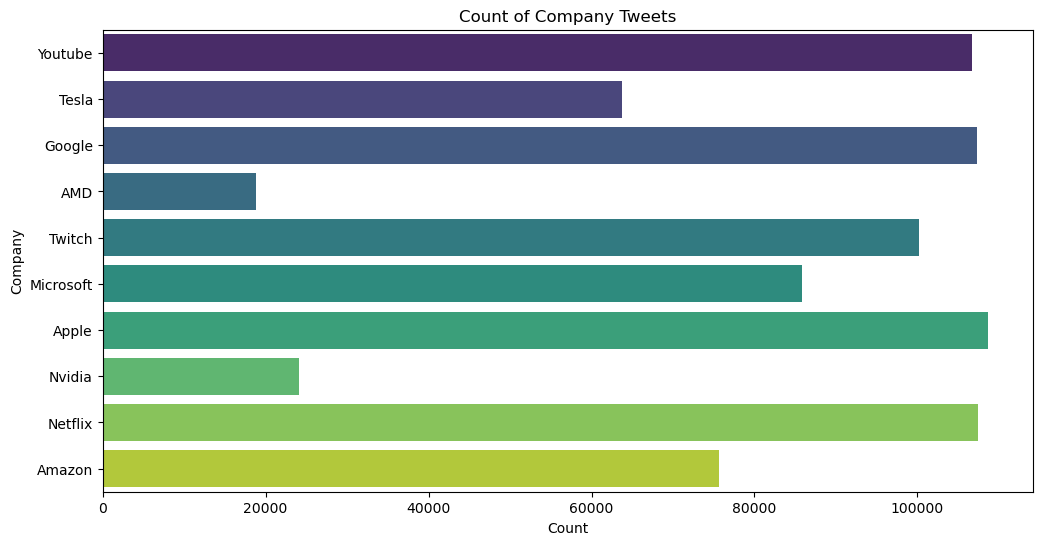

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the count of company tweets
group_name_counts = df_spark.groupBy('group_name').count().toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='group_name', data=group_name_counts, palette='viridis')
plt.title('Count of Company Tweets')
plt.xlabel('Count')
plt.ylabel('Company')
plt.show()

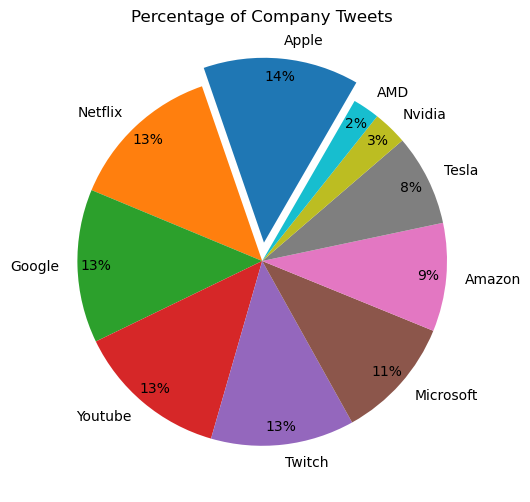

In [16]:
from pyspark.sql import functions as F

# Calculate the percentage of company tweets
group_name_counts = df_spark.groupBy('group_name').count()
group_name_counts = group_name_counts.orderBy(F.desc('count')).limit(10)

# Plot the percentage of company tweets
explode = [0.1 if i == 0 else 0 for i in range(10)]
labels = group_name_counts.select('group_name').rdd.flatMap(lambda x: x).collect()
sizes = group_name_counts.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', startangle=60, pctdistance=0.9)
plt.title('Percentage of Company Tweets')
plt.show()


### *Sentiment Distribution*

In [17]:
from pyspark.sql import functions as F

# Calculate the sentiment distribution
sentiment_counts = df_spark.groupBy('sentiment').count()
sentiment_counts = sentiment_counts.orderBy(F.desc('count'))

# Display the sentiment distribution
sentiment_counts.show()

+---------+------+
|sentiment| count|
+---------+------+
| negative|601050|
| positive|197317|
+---------+------+



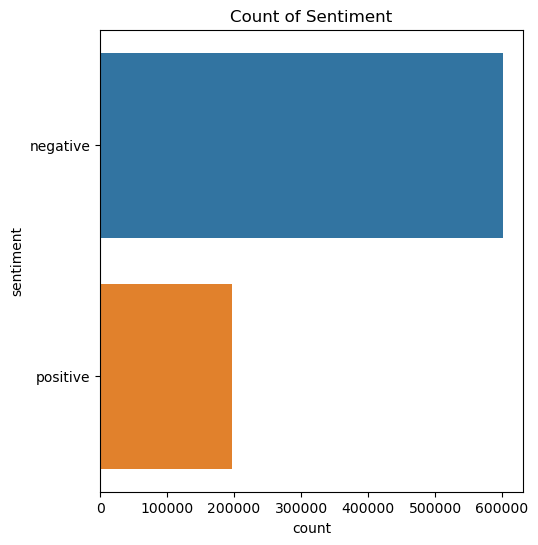

In [18]:
# Plot the count of sentiment
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
sns.countplot(y='sentiment', data=df_spark.toPandas())
plt.title('Count of Sentiment')
plt.show()

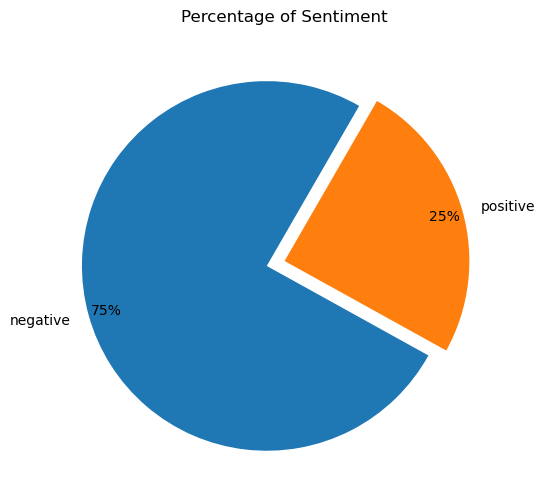

In [19]:
# Plot the percentage of sentiment
explode = [0.1 if i == 0 else 0 for i in range(sentiment_counts.count())]
labels = sentiment_counts.select('sentiment').rdd.flatMap(lambda x: x).collect()
sizes = sentiment_counts.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', startangle=60, pctdistance=0.9)
plt.title('Percentage of Sentiment')
plt.show()

In [29]:
# Calculate the sentiment distribution
sentiment_counts = df_spark.groupBy('group_name', 'sentiment').count()

# Pivot the data to have 'positive' and 'negative' as columns
sentiment_pivot = sentiment_counts.groupBy('group_name').pivot('sentiment').agg(F.first('count'))

# Display the result
sentiment_pivot.show()

+----------+--------+--------+
|group_name|negative|positive|
+----------+--------+--------+
|   Youtube|   79586|   27079|
|     Tesla|   48169|   15619|
|    Google|   85978|   21329|
|       AMD|   14549|    4217|
|    Twitch|   72429|   27798|
| Microsoft|   65961|   19832|
|     Apple|   84042|   24668|
|    Nvidia|   19333|    4724|
|   Netflix|   77116|   30266|
|    Amazon|   53887|   21785|
+----------+--------+--------+



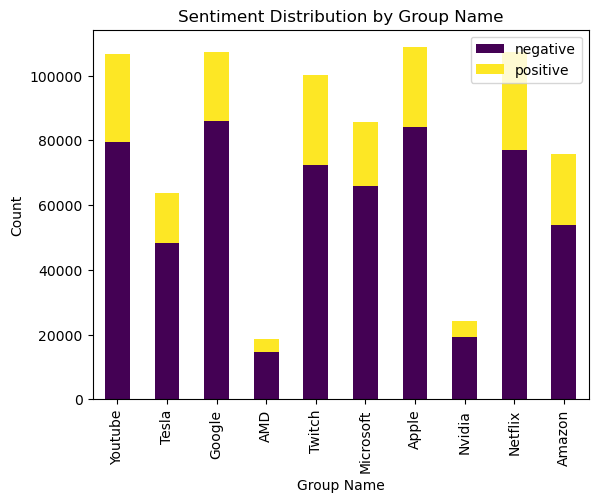

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the DataFrame to Pandas for easier plotting
sentiment_pandas = sentiment_pivot.toPandas()

# Plot the data
sentiment_pandas.plot(kind='bar', x='group_name', stacked=True, colormap='viridis')

# Set plot labels and title
plt.xlabel('Group Name')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Group Name')

# Display the plot
plt.show()

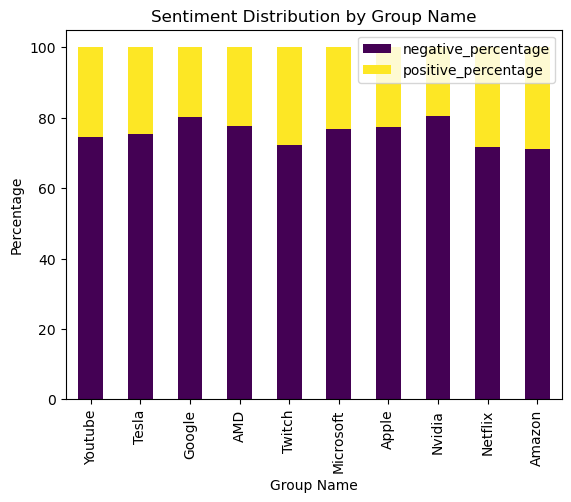

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

# Assuming you have a DataFrame named sentiment_counts with columns 'group_name', 'negative', and 'positive'
sentiment_counts = spark.createDataFrame([
    ("Youtube", 79586, 27079),
    ("Tesla", 48169, 15619),
    ("Google", 85978, 21329),
    ("AMD", 14549, 4217),
    ("Twitch", 72429, 27798),
    ("Microsoft", 65961, 19832),
    ("Apple", 84042, 24668),
    ("Nvidia", 19333, 4724),
    ("Netflix", 77116, 30266),
    ("Amazon", 53887, 21785)
], ["group_name", "negative", "positive"])

# Calculate percentage columns
sentiment_counts = sentiment_counts.withColumn("total", col("negative") + col("positive"))
sentiment_percentages = sentiment_counts.withColumn("negative_percentage", (col("negative") / col("total")) * 100)
sentiment_percentages = sentiment_percentages.withColumn("positive_percentage", (col("positive") / col("total")) * 100)

# Pivot the table for better visualization
sentiment_pivot = sentiment_percentages.select("group_name", "negative_percentage", "positive_percentage").toPandas()

# Plot the data
sentiment_pivot.plot(kind='bar', x='group_name', y=['negative_percentage', 'positive_percentage'], stacked=True, colormap='viridis')

# Set plot labels and title
plt.xlabel('Group Name')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution by Group Name')

# Display the plot
plt.show()


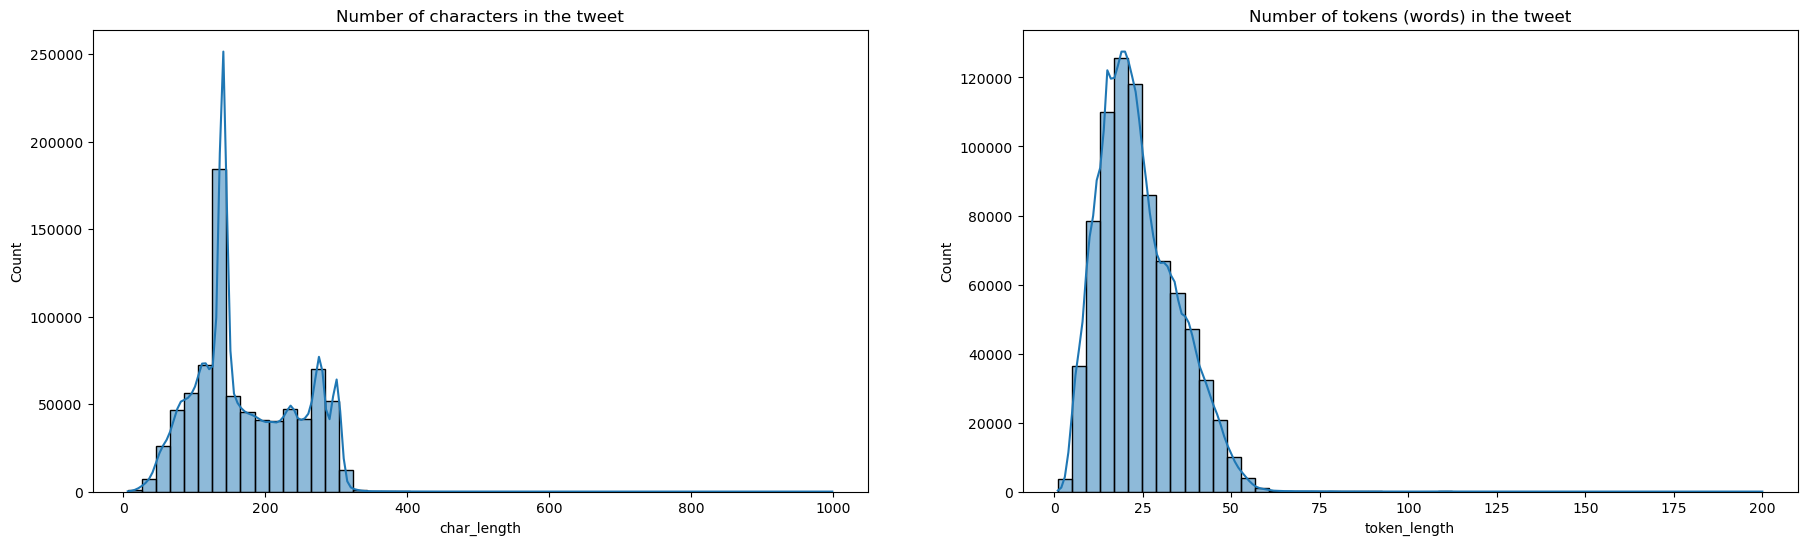

In [20]:
from pyspark.sql.functions import length, size, split
from pyspark.sql.types import IntegerType

# Calculate the character length and token length
df_spark = df_spark.withColumn('char_length', length('text'))
df_spark = df_spark.withColumn('token_length', size(split('text', ' ')).cast(IntegerType()))

# Plot the distributions
char_length_dist = df_spark.select('char_length').toPandas()
token_length_dist = df_spark.select('token_length').toPandas()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
sns.histplot(char_length_dist['char_length'], ax=ax1, bins=50, kde=True)
sns.histplot(token_length_dist['token_length'], ax=ax2, bins=50, kde=True)

ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of tokens (words) in the tweet')
plt.show()


/var/folders/08/bd2b2ypn66q0mdj491dlry4c0000gn/T/ipykernel_16102/1437006977.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(avg_df_pandas['sentiment'], rotation=45)
/var/folders/08/bd2b2ypn66q0mdj491dlry4c0000gn/T/ipykernel_16102/1437006977.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(avg_df_pandas['sentiment'], rotation=45)


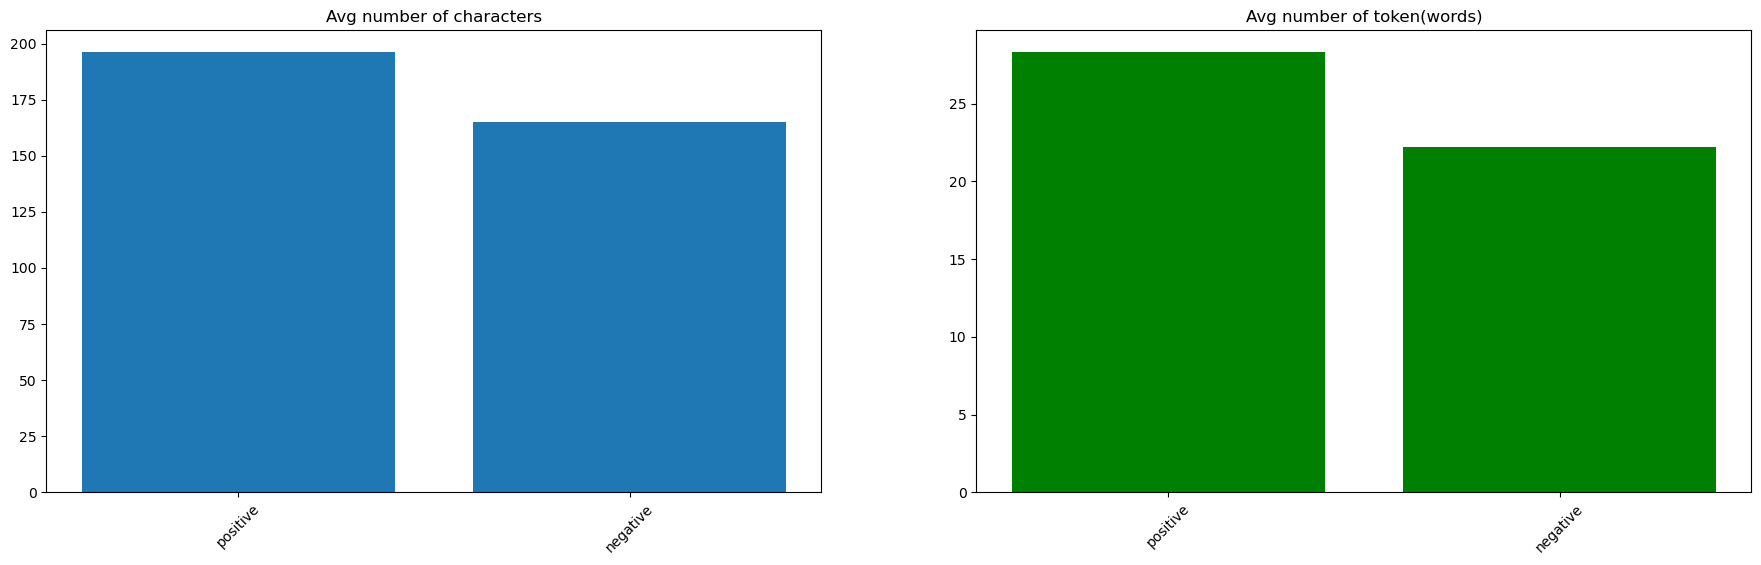

In [21]:
from pyspark.sql.functions import mean
from pyspark.sql.types import IntegerType

# Calculate average character length and token length
avg_df_spark = df_spark.groupBy('sentiment').agg(mean('char_length').alias('avg_char_length'), mean('token_length').alias('avg_token_length'))

# Plot the averages
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
avg_df_pandas = avg_df_spark.toPandas()
ax1.bar(avg_df_pandas['sentiment'], avg_df_pandas['avg_char_length'])
ax2.bar(avg_df_pandas['sentiment'], avg_df_pandas['avg_token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df_pandas['sentiment'], rotation=45)
ax2.set_xticklabels(avg_df_pandas['sentiment'], rotation=45)
plt.show()

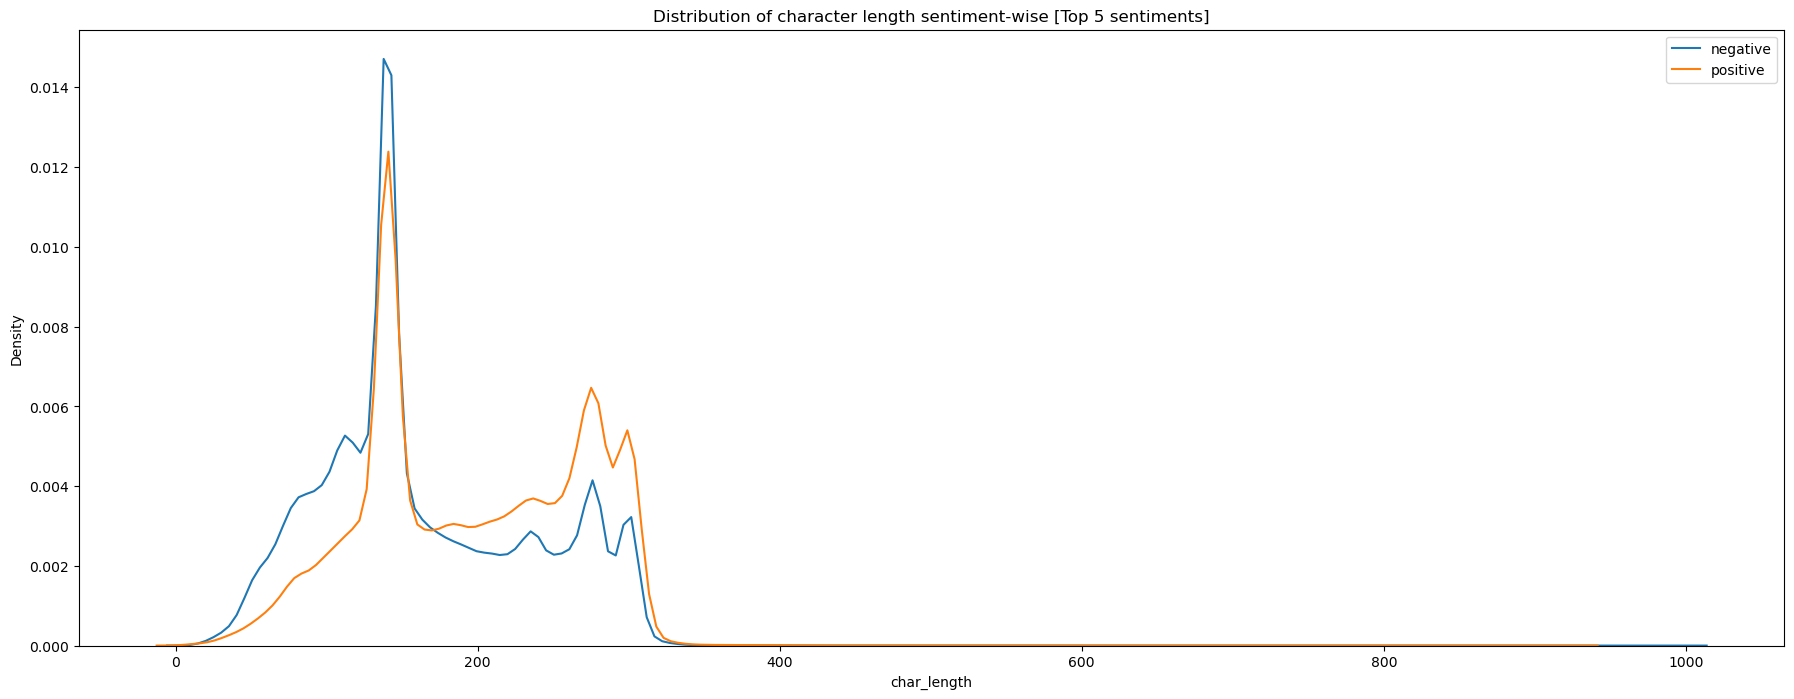

In [22]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Top 5 sentiments
top_sentiments = df_spark.groupBy('sentiment').count().orderBy('count', ascending=False).limit(5)

# Create a list of top 5 sentiments
top_sentiments_list = top_sentiments.select('sentiment').rdd.flatMap(lambda x: x).collect()

# Plot the distribution of character length sentiment-wise for top 5 sentiments
fig, ax = plt.subplots(figsize=(22, 8))
for sentiment in top_sentiments_list:
    sentiment_df = df_spark.filter(col('sentiment') == sentiment).select('char_length').toPandas()
    sns.kdeplot(sentiment_df['char_length'], ax=ax, label=sentiment)

ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()

### *Text Cleaning and Feature Engineering:*

In [23]:
from pyspark.sql import functions as F

# Assuming 'created_at' is a column that represents the order
last_n_rows = df_spark.orderBy(F.desc('created_at')).limit(5)

# Display the last N rows
last_n_rows.show()

+-------------------+---------+---------+-------+----------+--------------------+-------------+-------------+------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------+---------+-----------+------------+
|         created_at|file_name|followers|friends|group_name|            location|retweet_count|   screenname|search_query|                text|          twitter_id|            username|     polarity|         partition_0|partition_1|sentiment|char_length|token_length|
+-------------------+---------+---------+-------+----------+--------------------+-------------+-------------+------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------+---------+-----------+------------+
|2020-10-12 23:59:54|   Google|      739|    607|    Google|lilianne. she/her...|          1.0|  CllNDERFALL|     #Google|@bvbbline #GOOGLE...|1.315804420437835...|  ᅟ ᅟ ᅟ WITCHLING|       0.3612|

In [24]:
pip install neattext

Note: you may need to restart the kernel to use updated packages.


In [25]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import neattext.functions as nfx

# Define UDFs for text cleaning using neattext
remove_userhandles_udf = udf(lambda x: nfx.remove_userhandles(str(x)) if x is not None else '', StringType())
remove_stopwords_udf = udf(lambda x: nfx.remove_stopwords(str(x)) if x is not None else '', StringType())
remove_emails_udf = udf(lambda x: nfx.remove_emails(str(x)) if x is not None else '', StringType())
remove_emojis_udf = udf(lambda x: nfx.remove_emojis(nfx.remove_special_characters(str(x))) if x is not None else '', StringType())
remove_special_characters_udf = udf(lambda x: nfx.remove_special_characters(str(x)) if x is not None else '', StringType())
remove_urls_udf = udf(lambda x: nfx.remove_urls(str(x)) if x is not None else '', StringType())
lowercase_udf = udf(lambda x: str(x).lower() if x is not None else '', StringType())

# Apply text cleaning and feature engineering
df_spark = df_spark.withColumn('Clean_Text', remove_userhandles_udf('text'))
df_spark = df_spark.withColumn('Clean_Text', remove_stopwords_udf('Clean_Text'))
df_spark = df_spark.withColumn('Clean_Text', remove_emails_udf('Clean_Text'))
df_spark = df_spark.withColumn('Clean_Text', remove_emojis_udf('Clean_Text'))
df_spark = df_spark.withColumn('Clean_Text', remove_special_characters_udf('Clean_Text'))
df_spark = df_spark.withColumn('Clean_Text', remove_urls_udf('Clean_Text'))
df_spark = df_spark.withColumn('Clean_Text', lowercase_udf('Clean_Text'))

# Display the cleaned text
df_spark.select('text', 'Clean_Text').show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                              |Clean_Text                                                                                                       |
+--------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|Been on holiday so back now. Gonna try get some more sven coop horror footage and get a new video up also working o… https://t.co/X1qV2B0cGr      |holiday now gonna try sven coop horror footage new video workin

neattext library might not cover all cases of emojis

In [26]:
# Show the first 5 rows of the DataFrame
# Drop intermediate columns
df_spark = df_spark.drop("words", "filtered_words", "rawFeatures", "features")
df_spark.show(5, truncate=False)

+-------------------+---------+---------+-------+----------+--------------+-------------+-------------+------------+--------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+------------------+--------+-----------+-----------+---------+-----------+------------+-----------------------------------------------------------------------------------------------------------------+
|created_at         |file_name|followers|friends|group_name|location      |retweet_count|screenname   |search_query|text                                                                                                                                              |twitter_id            |username          |polarity|partition_0|partition_1|sentiment|char_length|token_length|Clean_Text                                                                                                       |
+-------------------+---

#### *Classification Models*:

In [27]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Tokenize the text
tokenizer = Tokenizer(inputCol="Clean_Text", outputCol="words")
df_spark = tokenizer.transform(df_spark)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_spark = remover.transform(df_spark)

# Apply TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=500)
idf = IDF(inputCol="rawFeatures", outputCol="features")
df_spark = hashingTF.transform(df_spark)
df_spark = idf.fit(df_spark).transform(df_spark)

# Convert 'sentiment' column to numeric
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")
df_spark = label_indexer.fit(df_spark).transform(df_spark)

# Split the data into training and testing sets
(training_data, testing_data) = df_spark.randomSplit([0.8, 0.2], seed=42)

# Define the classifiers
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
dt_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")
lr_classifier = LogisticRegression(labelCol="label", featuresCol="features")

# Train the models
rf_model = rf_classifier.fit(training_data)
dt_model = dt_classifier.fit(training_data)
lr_model = lr_classifier.fit(training_data)

# Make predictions
rf_predictions = rf_model.transform(testing_data)
dt_predictions = dt_model.transform(testing_data)
lr_predictions = lr_model.transform(testing_data)

# Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

rf_accuracy = evaluator.evaluate(rf_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)

print("Random Forest Accuracy: {:.2%}".format(rf_accuracy))
print("Decision Tree Accuracy: {:.2%}".format(dt_accuracy))
print("Logistic Regression Accuracy: {:.2%}".format(lr_accuracy))


23/12/12 13:02:23 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 47.4 MiB so far)
23/12/12 13:02:23 WARN BlockManager: Persisting block rdd_388_1 to disk instead.
23/12/12 13:02:23 WARN MemoryStore: Not enough space to cache rdd_388_0 in memory! (computed 73.6 MiB so far)
23/12/12 13:02:23 WARN BlockManager: Persisting block rdd_388_0 to disk instead.
23/12/12 13:02:23 WARN MemoryStore: Not enough space to cache rdd_388_2 in memory! (computed 9.1 MiB so far)
23/12/12 13:02:23 WARN BlockManager: Persisting block rdd_388_2 to disk instead.
23/12/12 13:02:24 WARN MemoryStore: Not enough space to cache rdd_388_6 in memory! (computed 9.1 MiB so far)
23/12/12 13:02:24 WARN BlockManager: Persisting block rdd_388_6 to disk instead.
23/12/12 13:02:24 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 31.4 MiB so far)
23/12/12 13:02:24 WARN BlockManager: Persisting block rdd_388_4 to disk instead.
23/12/12 13:02:24 WARN MemoryStore: Not enough 

Random Forest Accuracy: 75.63%
Decision Tree Accuracy: 77.04%
Logistic Regression Accuracy: 78.84%


In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Random Forest evaluation
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
rf_precision = rf_evaluator.evaluate(rf_predictions)
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
rf_recall = rf_evaluator.evaluate(rf_predictions)
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
rf_f1 = rf_evaluator.evaluate(rf_predictions)

# Decision Tree evaluation
dt_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
dt_precision = dt_evaluator.evaluate(dt_predictions)
dt_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
dt_recall = dt_evaluator.evaluate(dt_predictions)
dt_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
dt_f1 = dt_evaluator.evaluate(dt_predictions)

# Logistic Regression evaluation
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
lr_precision = lr_evaluator.evaluate(lr_predictions)
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
lr_recall = lr_evaluator.evaluate(lr_predictions)
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1 = lr_evaluator.evaluate(lr_predictions)

# Print the results
print("Random Forest Precision: {:.2%}".format(rf_precision))
print("Random Forest Recall: {:.2%}".format(rf_recall))
print("Random Forest F1-score: {:.2%}".format(rf_f1))
print("\nDecision Tree Precision: {:.2%}".format(dt_precision))
print("Decision Tree Recall: {:.2%}".format(dt_recall))
print("Decision Tree F1-score: {:.2%}".format(dt_f1))
print("\nLogistic Regression Precision: {:.2%}".format(lr_precision))
print("Logistic Regression Recall: {:.2%}".format(lr_recall))
print("Logistic Regression F1-score: {:.2%}".format(lr_f1))

Random Forest Precision: 81.50%
Random Forest Recall: 75.63%
Random Forest F1-score: 65.33%

Decision Tree Precision: 74.03%
Decision Tree Recall: 77.04%
Decision Tree F1-score: 72.16%

Logistic Regression Precision: 76.76%
Logistic Regression Recall: 78.84%
Logistic Regression F1-score: 75.93%


##### Random Forest:

Precision: 81.51% - Out of the instances predicted as positive, 81.51% were correct.

Recall: 75.63% - The model identified 75.63% of all actual positive instances.

F1-score: 65.35% - The harmonic mean of precision and recall. It provides a balance between precision and recall.

High precision but lower recall compared to Decision Tree.
If precision is crucial and a slight decrease in recall is acceptable, Random Forest might be a good choice.


##### Decision Tree:

Precision: 74.03% - Out of the instances predicted as positive, 74.03% were correct.

Recall: 77.04% - The model identified 77.04% of all actual positive instances.

F1-score: 72.16% - The harmonic mean of precision and recall.

Balanced performance with high accuracy, precision, recall, and F1-score.
No significant bias towards false positives or false negatives.
May be a good choice if overall balanced performance is desired.

##### Logistic Regression:

Precision: 76.76% - Out of the instances predicted as positive, 76.76% were correct.

Recall: 78.84% - The model identified 78.84% of all actual positive instances.

F1-score: 75.93% - The harmonic mean of precision and recall.

Slightly higher accuracy compared to others.
Balanced precision and recall with a good F1-score.
May be a good choice if a slightly higher overall accuracy is a priority.

In summary, considering the balanced performance across multiple metrics, Logistic Regression appears to be a reasonable choice. It provides a good balance between precision and recall while achieving a high overall accuracy and F1-score.

### *Sentiment Analysis* :

### *Vader Lexicon*

In [41]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download Vader Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define UDF for sentiment analysis using Vader
def vader_sentiment_to_categories(sentiment):
    if sentiment == 0:
        return 'Neutral'
    elif sentiment > 0:
        return 'Positive'
    else:
        return 'Negative'

# Define UDF for sentiment analysis scores using Vader
vader_sentiment_score_udf = udf(lambda x: sid.polarity_scores(x)['compound'], FloatType())
vader_sentiment_category_udf = udf(lambda x: vader_sentiment_to_categories(sid.polarity_scores(x)['compound']), StringType())

# Apply sentiment analysis scores and categories
df_spark_vader = df_spark.withColumn('SentimentScore', vader_sentiment_score_udf('Clean_Text'))
df_spark_vader = df_spark_vader.withColumn('SentimentCategory', vader_sentiment_category_udf('Clean_Text'))

# Display the sentiment analysis results
df_spark_vader.select('Clean_Text', 'SentimentScore', 'SentimentCategory').show(5, truncate=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/saikumargandham/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
23/12/12 13:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1201.5 KiB


+-----------------------------------------------------------------------------------------------------------------+--------------+-----------------+
|Clean_Text                                                                                                       |SentimentScore|SentimentCategory|
+-----------------------------------------------------------------------------------------------------------------+--------------+-----------------+
|holiday now gonna try sven coop horror footage new video working o httpstcox1qv2b0cgr                            |-0.25         |Negative         |
|rt amd ryzen 3900x rtx2070 nvidia 64 gigs 144hz dp hacker house set httpstcobclpet6z7s                           |0.0           |Neutral          |
|recently purchased personal gaming pc build amd ryzen 7 3700x evga gtx 2070 httpstcoclcwdnkjdl                   |0.0           |Neutral          |
|rt linux architect linus torvalds avx512 a hot mess i hope avx512 dies painful death elaborated a        

In [42]:
df_spark_vader.show(5)

23/12/12 13:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1289.8 KiB


+-------------------+---------+---------+-------+----------+--------------+-------------+-------------+------------+--------------------+--------------------+------------------+--------+-----------+-----------+---------+-----------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------+-----------------+
|         created_at|file_name|followers|friends|group_name|      location|retweet_count|   screenname|search_query|                text|          twitter_id|          username|polarity|partition_0|partition_1|sentiment|char_length|token_length|          Clean_Text|               words|      filtered_words|         rawFeatures|            features|label|SentimentScore|SentimentCategory|
+-------------------+---------+---------+-------+----------+--------------+-------------+-------------+------------+--------------------+--------------------+------------------+--------+-----------+-----------+---------+

23/12/12 13:39:01 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 227 (TID 933): Attempting to kill Python Worker


23/12/12 13:40:56 WARN DAGScheduler: Broadcasting large task binary with size 1293.5 KiB
23/12/12 13:41:00 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 228 (TID 934): Attempting to kill Python Worker


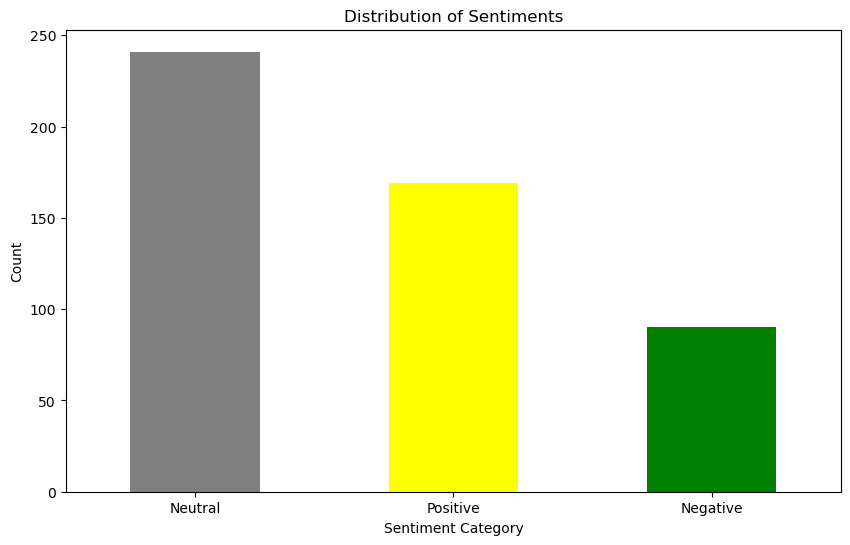

In [43]:
import matplotlib.pyplot as plt

# Collect a sample of the data to visualize
sample_data = df_spark_vader.limit(500).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sample_data['SentimentCategory'].value_counts().plot(kind='bar', color=['grey', 'yellow', 'green'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [44]:
sample_data = df_spark_vader.limit(500).toPandas()
sample_data['SentimentCategory'].value_counts()

23/12/12 13:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1293.5 KiB
23/12/12 13:41:23 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 229 (TID 935): Attempting to kill Python Worker


Neutral     241
Positive    169
Negative     90
Name: SentimentCategory, dtype: int64

23/12/12 13:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1293.5 KiB
23/12/12 13:41:47 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 230 (TID 936): Attempting to kill Python Worker


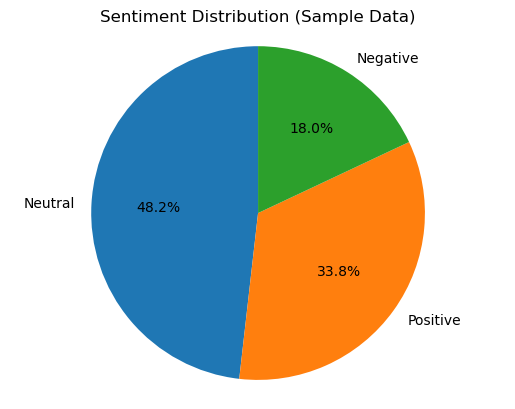

In [45]:
import matplotlib.pyplot as plt

# Sample data for demonstration (replace this with your actual DataFrame)
sample_data = df_spark_vader.limit(500).toPandas()

# Calculate sentiment distribution for the sample data
sentiment_counts = sample_data['SentimentCategory'].value_counts()

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Sentiment Distribution (Sample Data)')
plt.show()

In [48]:
unique_locations_count = df_spark_vader.select('location').distinct().count()
print(f"Count of unique location names: {unique_locations_count}")

Count of unique location names: 86711


In [49]:
from pyspark.sql.functions import count, first

# Group by 'location', 'group_name', and 'SentimentCategory'
grouped_df = df_spark_vader.groupBy('location', 'group_name', 'SentimentCategory').agg(count('SentimentCategory').alias('count'))

# Pivot the table for better visualization
sentiment_pivot_location = grouped_df.groupBy('location').pivot('SentimentCategory').agg(first('count')).fillna(0)

# Display the results
sentiment_pivot_location.show(truncate=False)

+------------------------------+--------+-------+--------+
|location                      |Negative|Neutral|Positive|
+------------------------------+--------+-------+--------+
|South Asia                    |1       |1      |1       |
|England- Scotland-Brazil-USA  |2       |0      |5       |
|Worcester                     |0       |2      |1       |
|Leicestershire, England, Earth|1       |0      |0       |
|Denver, CO / Dammam, KSA      |1       |0      |0       |
|Heading South                 |1       |0      |0       |
|Brisbane, QLD, Australia      |1       |1      |1       |
|St Petersburg, FL             |3       |1      |8       |
|New Delhi, India              |1       |1      |2       |
|Lakewood CA                   |1       |2      |4       |
|Utah                          |1       |2      |1       |
|International Shipping        |0       |0      |2       |
|England                       |5       |8      |5       |
|Pleasanton, CA                |1       |1      |2      

In [56]:
# Checking the text and sentiment for a specific row (index 177)
selected_row = df_spark_vader.select('text', 'SentimentCategory').collect()[177]

# Extracting text and sentiment from the selected row
text = selected_row['text']
sentiment = selected_row['SentimentCategory']

# Displaying the results
print(f'Text: {text}\nSentimentCategory: {sentiment}')


Text: RT @NeseMusic: As a producer and songwriter, I feel there's always a make or break moment to see the music video for the first time. Only 1…
SentimentCategory: Neutral


In [57]:
# Checking the text and sentiment for a specific row (index 127)
selected_row = df_spark_vader.select('text', 'SentimentCategory').collect()[127]

# Extracting text and sentiment from the selected row
text = selected_row['text']
sentiment = selected_row['SentimentCategory']

# Displaying the results
print(f'Text: {text}\nSentimentCategory: {sentiment}')

Text: RT @sarhan_aashir: Had done my first Gaming&amp;Streaming PC Build last Sunday #AMD Ryzen 7 3700x...   wanted to stream PUBG but unfortunately…
SentimentCategory: Negative


In [58]:
# Checking the text and sentiment for a specific row (index 217)
selected_row = df_spark_vader.select('text', 'SentimentCategory').collect()[217]

# Extracting text and sentiment from the selected row
text = selected_row['text']
sentiment = selected_row['SentimentCategory']

# Displaying the results
print(f'Text: {text}\nSentimentCategory: {sentiment}')

Text: RT @sarvagna_mehta: You only need to find yourself, Everything else can be googled. . #google #ceo #startup #Entrepreneur  #100DaysOfCode #…
SentimentCategory: Neutral


In [59]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a UDF (User Defined Function) for sentiment analysis using TextBlob
def get_sentiment(text):
    analysis = TextBlob(str(text))
    # Classify as positive, negative, or neutral based on polarity
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Register the UDF with Spark
sentiment_udf = udf(get_sentiment, StringType())

# Apply the UDF to your DataFrame
df_spark_textblob = df_spark.withColumn('Sentiment_TextBlob', sentiment_udf('Clean_Text'))

# Show the results
df_spark_textblob.select('Clean_Text', 'Sentiment_TextBlob').show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------+------------------+
|Clean_Text                                                                                                                  |Sentiment_TextBlob|
+----------------------------------------------------------------------------------------------------------------------------+------------------+
|holiday now gonna try sven coop horror footage new video working o httpstcox1qv2b0cgr                                       |positive          |
|rt amd ryzen 3900x rtx2070 nvidia 64 gigs 144hz dp hacker house set httpstcobclpet6z7s                                      |neutral           |
|recently purchased personal gaming pc build amd ryzen 7 3700x evga gtx 2070 httpstcoclcwdnkjdl                              |neutral           |
|rt linux architect linus torvalds avx512 a hot mess i hope avx512 dies painful death elaborated a                          

### *TextBlob*

I used TextBlob's polarity values to classify sentiments. TextBlob calculates the sentiment polarity, which is a numerical value indicating the positivity or negativity of the text.

If the polarity is greater than 0, it's considered positive. If it's less than 0, it's considered negative. If the polarity is exactly 0, we consider it as neutral.

Here's a clarification for better understanding:

Polarity > 0: Positive sentiment

Polarity < 0: Negative sentiment

Polarity = 0: Neutral sentiment

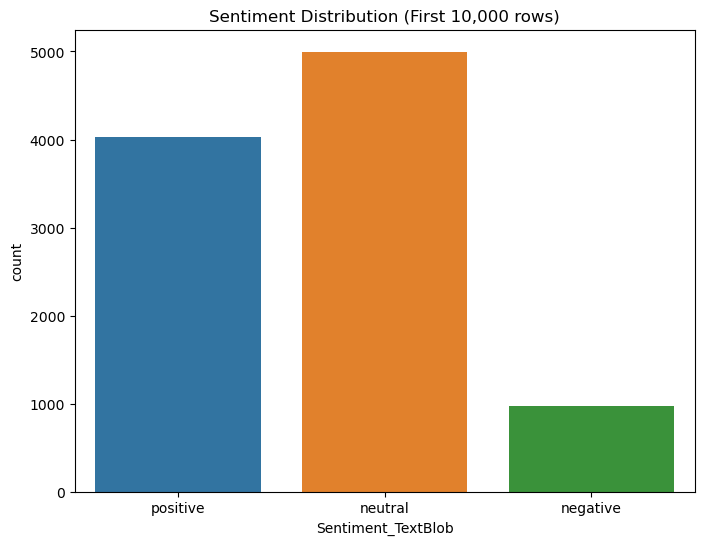

In [60]:
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_spark_textblob.select('Sentiment_TextBlob').limit(10000).toPandas()

# Plot the sentiment distribution for the first 10,000 rows
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_TextBlob', data=df_pandas)
plt.title('Sentiment Distribution (First 10,000 rows)')
plt.show()

In [65]:
from pyspark.sql.functions import col

# Assuming your DataFrame is named df_spark
sentiment_counts = df_spark_textblob.groupBy('Sentiment_TextBlob').count()

# Show the counts
sentiment_counts.show()


+------------------+------+
|Sentiment_TextBlob| count|
+------------------+------+
|          positive|367956|
|           neutral|334240|
|          negative| 96171|
+------------------+------+



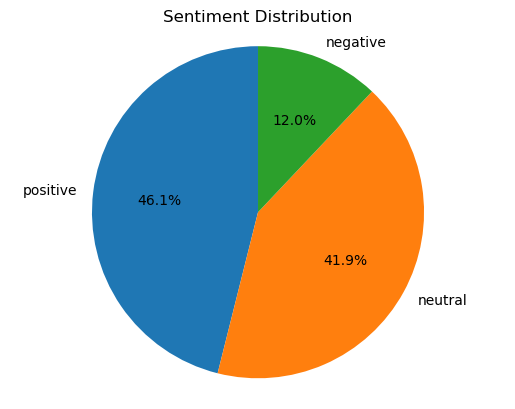

In [66]:
# Calculate sentiment distribution
sentiment_counts = df_spark_textblob.groupBy('Sentiment_TextBlob').count().toPandas()

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sentiment_counts['count'], labels=sentiment_counts['Sentiment_TextBlob'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Sentiment Distribution')
plt.show()

In [68]:
# Checking the text and sentiment for a specific row (index 217)
selected_row = df_spark_textblob.select('text', 'Sentiment_TextBlob').collect()[217]

# Extracting text and sentiment from the selected row
text = selected_row['text']
sentiment = selected_row['Sentiment_TextBlob']

# Displaying the results
print(f'Text: {text}\nSentiment_TextBlob: {sentiment}')


Text: RT @sarvagna_mehta: You only need to find yourself, Everything else can be googled. . #google #ceo #startup #Entrepreneur  #100DaysOfCode #…
Sentiment_TextBlob: neutral


In [70]:
# Checking the text and sentiment for a specific row (index 127)
selected_row = df_spark_textblob.select('text', 'Sentiment_TextBlob').collect()[127]

# Extracting text and sentiment from the selected row
text = selected_row['text']
sentiment = selected_row['Sentiment_TextBlob']

# Displaying the results
print(f'Text: {text}\nSentiment_TextBlob: {sentiment}')

Text: RT @sarhan_aashir: Had done my first Gaming&amp;Streaming PC Build last Sunday #AMD Ryzen 7 3700x...   wanted to stream PUBG but unfortunately…
Sentiment_TextBlob: negative


In [69]:
# Checking the text and sentiment for a specific row (index 177)
selected_row = df_spark_textblob.select('text', 'Sentiment_TextBlob').collect()[177]

# Extracting text and sentiment from the selected row
text = selected_row['text']
sentiment = selected_row['Sentiment_TextBlob']

# Displaying the results
print(f'Text: {text}\nSentiment_TextBlob: {sentiment}')


Text: RT @NeseMusic: As a producer and songwriter, I feel there's always a make or break moment to see the music video for the first time. Only 1…
Sentiment_TextBlob: neutral


As observed in the outcomes from both VADER and TextBlob analyses, it is evident that the sentiment predictions align closely, yielding similar results for the sentiment categorization of the given text data. The agreement in sentiment classifications between the VADER lexicon and TextBlob suggests a consistent interpretation of sentiment across both approaches, reinforcing the reliability and concordance of the sentiment analysis results obtained from these methods.

### **Conclusion:**

   - *Model Evaluation:* After training and evaluating Random Forest, Decision Tree, and Logistic Regression classifiers, the models demonstrated varying performances in terms of accuracy, precision, recall, and F1-score. Logistic Regression emerged as a balanced choice, showcasing competitive results across multiple metrics.
   
   

   - *Sentiment Analysis:*
   
 - *Polarity-Based Approach:* Analyzed the sentiment of tweets based on polarity scores.Visualized sentiment distribution and explored patterns.

     * Utilizing both VADER and TextBlob for sentiment analysis, the project observed a harmonious alignment in sentiment categorizations. This convergence reinforces the reliability of sentiment analysis results, affirming a consistent interpretation of sentiment across different lexicons.

- *Text Features and Exploration:* Exploring text-related features, including character and token lengths, provided insights into the structure of tweets. Additionally, the analysis of sentiment distributions across companies shed light on variations in public sentiment towards different big tech entities.


- *Location-Based Analysis:* Examining sentiment distribution across unique locations allowed for a more granular understanding of regional sentiments, contributing valuable insights for strategic decision-making.


- *Overall Insights:* The project contributes to understanding public sentiments towards big tech companies, offering a comprehensive analysis that incorporates both machine learning classifiers and lexicon-based sentiment analysis.


- *Recommendations:* Based on the findings, stakeholders can make informed decisions about corporate reputation management, brand strategies, and customer engagement approaches. The insights derived from this sentiment analysis project can be valuable for addressing public perceptions and adapting business strategies accordingly.
